## Demo Class Camera

In [1]:
import matplotlib.pylab as plt
import numpy as np
# from cv2 import putText,imencode,FONT_HERSHEY_SIMPLEX,LINE_4,resize, Canny, addWEight
import cv2
import time
import threading
import os
# append system.path with the folder containing basisklassen_cam,.py
import sys
sys.path.append('./../Software')
from basisklassen_cam import Camera
import ipywidgets as widgets
from IPython.display import display

In [ ]:
Camera?

### OpenCV only

True


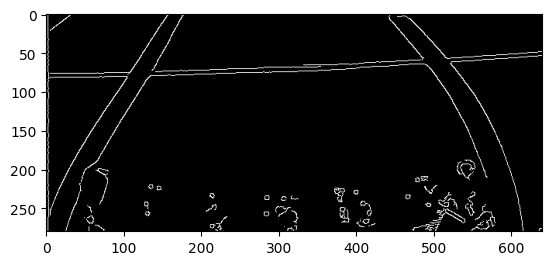

In [110]:
import cv2
vc = cv2.VideoCapture(0)
ret,frame = vc.read()
frame = cv2.flip(frame,-1)
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
frame = cv2.blur(frame, (5,5))
frame = cv2.Canny(frame, 0, 100)
frame = cv2.normalize(frame, frame, alpha=5, norm_type=cv2.NORM_MINMAX)
# threshold=60
# ret,frame = cv2.threshold(frame,threshold,1,cv2.THRESH_BINARY)   # gibt threshold und Resultat zurück
frame = frame[200:480,0:640].copy()
print(ret)
plt.imshow(frame, cmap='gray')



Template <class 'numpy.ndarray'> (70, 540)


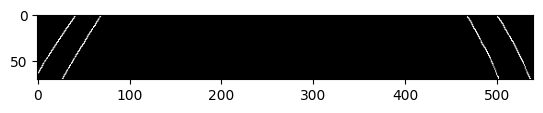

In [107]:
imgTemplate = frame[100:170,50:590].copy()
# threshold=10
# ret,imgTemplate = cv2.threshold(imgTemplate,threshold,1,cv2.THRESH_BINARY)   # gibt threshold und Resultat zurück
plt.imshow(imgTemplate,cmap='gray')
print('Template',type(imgTemplate),imgTemplate.shape)




8.0 129009600.0 (50, 100) (1, 209)
(50, 100)
(590, 170)


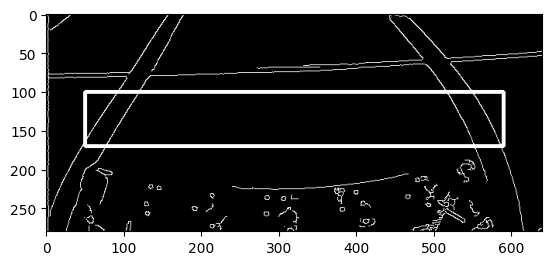

In [108]:
res = cv2.matchTemplate(frame, imgTemplate,cv2.TM_SQDIFF) 
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
print(min_val, max_val, min_loc, max_loc)

top_left = min_loc

#-------------------------
# Zeichnen der Boundary Box
ht,wt = imgTemplate.shape
bottom_right = (top_left[0] + wt, top_left[1] + ht)
img3=cv2.rectangle(frame.copy(), top_left, bottom_right, (255,0,0), 3)
#img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2RGB)

plt.imshow(img3, cmap='gray')
print(top_left)
print(bottom_right)



In [ ]:
vc.release()